# X-RAY Dataset Classification
* ### 정상인의 흉부 x-ray사진과 페렴에 걸린 흉부 x-ray사진들이 있는 데이터 셋이다. 이 사진들을 보고 정상과 페렴을 구분 하는 CNN모델을 구현했다.
* ### 이 데이터를 선택한 이유: 잘 정리된 데이터가 아닌 실제 상황에서 만날 수 있는 데이터와 비슷한 데이터셋을 선택하고 싶었다. 데이터가 충분하지 않고 균형을 이루고 있지 않은 데이터를 만날 일이 많기 때문에 이 데이터셋으로 미리 경험해보고 싶었다.

## import

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras import applications
from keras import backend as K
from keras.optimizers import SGD
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from os import listdir
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img
from keras.utils import np_utils
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from keras.wrappers.scikit_learn import KerasClassifier 



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## data split

### 변수,리스트 초기화

In [0]:
train_data = []
train_labels = []
test_data = []
test_labels = []
valid_data = []
valid_labels = []
im_width = 256
im_height = 256
num_classes = 2

### 이미지 넣어주는 함수

In [0]:
def preProcessTrainData(path):
    i = 0
    p = 0
    s = ["PNEUMONIA","NORMAL"]
    folders = [f for f in os.listdir(path)]
    for folder in folders:
        image_files = [f for f in os.listdir(path+'/'+folder)]
        num = 1
        for file_name in image_files:
            image_file = str(path +'/'+ folder+'/' +file_name)
        
            img = cv2.imread(image_file,cv2.IMREAD_GRAYSCALE)
            new_img = cv2.resize(img,(im_width,im_height))
                
            train_data.append(new_img)
            train_labels.append(i)
            if p % 200 == 0:
                print(p)
            p = p + 1
            num = num + 1
        i = i + 1

In [0]:
def preProcessTestData(path):
    i = 1
    p = 0
    s = ["PNEUMONIA","NORMAL"]
    folders = [f for f in os.listdir(path)]
    for folder in folders:
        image_files = [f for f in os.listdir(path+'/'+folder)]
        num = 1
        for file_name in image_files:
            image_file = str(path +'/'+ folder+'/' +file_name)
        
            img = cv2.imread(image_file,cv2.IMREAD_GRAYSCALE)
            new_img = cv2.resize(img,(im_width,im_height))
                
            test_data.append(new_img)
            test_labels.append(i)
            if p % 50 == 0:
                print(p)
            p = p + 1
            num = num + 1
        i = i - 1

In [0]:
def preProcessTrain2Data(path):
    i = 0
    p = 0
    s = ["PNEUMONIA","NORMAL"]
    folders = [f for f in os.listdir(path)]
    folder = 'NORMAL'
    image_files = [f for f in os.listdir(path+'/'+folder)]
    num = 1
    for file_name in image_files:
        image_file = str(path +'/'+ folder+'/' +file_name)
        
        img = cv2.imread(image_file,cv2.IMREAD_GRAYSCALE)
        new_img = cv2.resize(img,(im_width,im_height))
                
        train_data.append(new_img)
        train_labels.append(i)
        if p % 100 == 0:
            print(p)
        p = p + 1
        num = num + 1
    i = i + 1

In [0]:
def preProcessValidData(path):
    i = 0
    p = 0
    s = ["PNEUMONIA","NORMAL"]
    folders = [f for f in os.listdir(path)]
    for folder in folders:
        image_files = [f for f in os.listdir(path+'/'+folder)]
        num = 1
        for file_name in image_files:
            image_file = str(path +'/'+ folder+'/' +file_name)
        
            img = cv2.imread(image_file,cv2.IMREAD_GRAYSCALE)
            new_img = cv2.resize(img,(im_width,im_height))
                
            valid_data.append(new_img)
            valid_labels.append(i)
            if p % 10 == 0:
                print(p)
            p = p + 1
            num = num + 1
        i = i + 1

### 이미지 불러오기

In [0]:
##처음하면 엄청 오래걸림
preProcessTrainData("./gdrive/My Drive/chest_xray/train/")
preProcessTestData("./gdrive/My Drive/chest_xray/test/")
preProcessValidData("./gdrive/My Drive/chest_xray/val/")


### 배열로 변환, 확인하기

In [0]:
train_data = np.array(train_data)
test_data = np.array(test_data)
valid_data = np.array(valid_data)
print(train_data.shape)
print(test_data.shape)
print(valid_data.shape)

(5235, 256, 256)
(624, 256, 256)
(16, 256, 256)


In [0]:
print(train_labels[0])
print(sum(train_labels))

0
3894


In [0]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)
valid_labels = np.array(valid_labels)
print(train_labels.shape)
print(test_labels.shape)
print(valid_labels.shape)

(5235,)
(624,)
(16,)


## reshape

### 데이터 변환하기

In [0]:
##reshape
train_data = train_data.reshape((train_data.shape)[0],(train_data.shape)[1],(train_data.shape)[2],1).astype('float32')/255
test_data = test_data.reshape((test_data.shape)[0],(test_data.shape)[1],(test_data.shape)[2],1).astype('float32')/255
valid_data = valid_data.reshape((valid_data.shape)[0],(valid_data.shape)[1],(valid_data.shape)[2],1).astype('float32')/255
print(train_data.shape)
print(test_data.shape)
print(valid_data.shape)

(5235, 256, 256, 1)
(624, 256, 256, 1)
(16, 256, 256, 1)


### one-hot 인코딩

In [0]:
train_labels.astype('uint8')
test_labels.astype('uint8')
valid_labels.astype('uint8')
train_labels = keras.utils.to_categorical(train_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)
valid_labels = keras.utils.to_categorical(valid_labels, num_classes) #one hot encoding
print(train_labels.shape)
print(test_labels.shape)
print(valid_labels.shape)

# train_labels = np_utils.to_categorical(train_labels, num_classes = 18)     #one-hot-encoding 하는 코드
# test_labels = np_utils.to_categorical(test_labels, num_classes = 18)    #위에꺼는 이거랑 차원이 다르다

(5235, 2)
(624, 2)
(16, 2)


## image check

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


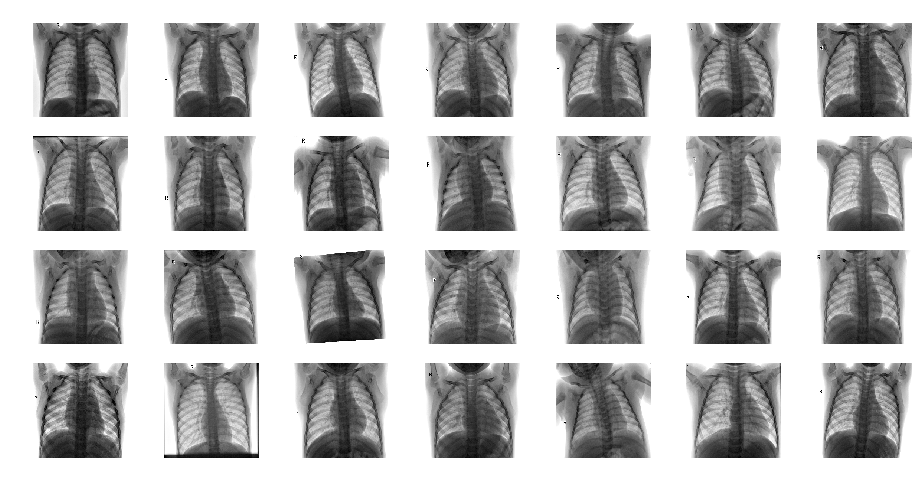

In [0]:

#Y_categ = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig, ax = plt.subplots(4, 7, figsize = (16, 8))
ax = ax.ravel()
for i in range(28):
    ax[i].imshow(train_data[i, :, :, :].reshape(256, 256), cmap='binary')
    ax[i].set_title(train_labels[i], color='white')
    ax[i].axis('off')
plt.show()

## keras model

### 순서 섞기

In [0]:
def shuffle(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
for i in range(2):
    shuffle(train_data,train_labels)
# print(train_labels[0:100])

### 모형 층 설계

In [0]:
model = Sequential()
model.add(Conv2D(kernel_size=(3,3),filters=32,input_shape=(256, 256,
1),activation = 'relu',padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(kernel_size=(3,3),filters=32,activation="relu",padding="same"))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Conv2D(kernel_size=(3,3),activation="relu",filters=48, padding = 'same'))
# model.add(BatchNormalization())
# # model.add(Conv2D(kernel_size=(3,3),activation="relu",filters=32))
# # model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.3))

model.add(Conv2D(kernel_size=(3,3),filters=64,padding="same"))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(kernel_size=(3,3),filters=256,activation="relu",padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(kernel_size=(3,3),filters=256,padding="same"))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(kernel_size=(3,3),filters=256,activation="relu",padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Flatten())
model.add(Dense(1024,activation="relu",kernel_regularizer=keras.regularizers.l2(0.05)))
model.add(Dropout(0.4))
model.add(Dense(1024,activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(num_classes,activation="softmax"))

model.compile(loss='categorical_crossentropy',
#               optimizer=keras.optimizers.Adam,
              optimizer ='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 256, 256, 32)      320       
_________________________________________________________________
batch_normalization_21 (Batc (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_22 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
dropout_21 (Dropout)         (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 64, 64, 32)        0         
__________

### 학습하기

In [0]:
history = model.fit(train_data, train_labels,
          batch_size=128,
          epochs=7,
          verbose=1,shuffle = True, validation_split=0.15)

# hist1 = model1.fit(X_train, Y_train, epochs=30, batch_size=100,
#                    validation_data=(X_test, Y_test), verbose=0)

Train on 4449 samples, validate on 786 samples
Epoch 1/7
4449/4449 [==============================] - 24s 5ms/step - loss: 32.5382 - acc: 0.7363 - val_loss: 6.2869 - val_acc: 0.7557
Epoch 2/7
4449/4449 [==============================] - 15s 3ms/step - loss: 3.5533 - acc: 0.7653 - val_loss: 2.9944 - val_acc: 0.8079
Epoch 3/7
4449/4449 [==============================] - 15s 3ms/step - loss: 0.9143 - acc: 0.9341 - val_loss: 4.3228 - val_acc: 0.7557
Epoch 4/7
4449/4449 [==============================] - 15s 3ms/step - loss: 0.3696 - acc: 0.9616 - val_loss: 3.4384 - val_acc: 0.7557
Epoch 5/7
4449/4449 [==============================] - 15s 3ms/step - loss: 0.2460 - acc: 0.9690 - val_loss: 3.9832 - val_acc: 0.7557
Epoch 6/7
4449/4449 [==============================] - 15s 3ms/step - loss: 0.2674 - acc: 0.9697 - val_loss: 3.8516 - val_acc: 0.7557
Epoch 7/7
4449/4449 [==============================] - 15s 3ms/step - loss: 0.1822 - acc: 0.9757 - val_loss: 4.0196 - val_acc: 0.7557


## check

### Loss 그래프

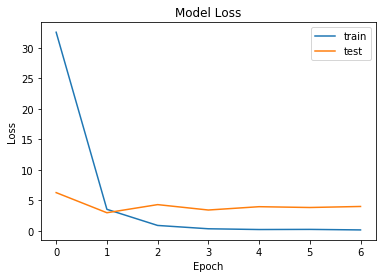

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


### Accuracy 그래프

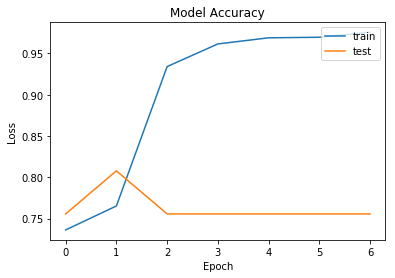

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Test셋과 Valid셋으로 정확도 측정

In [0]:
score = model.evaluate(test_data , test_labels)
score1 = model.evaluate(valid_data, valid_labels)

16/16 [==============================] - 0s 1ms/step


In [0]:
print("Test loss: ", score[0])
print("Test accuracy: ", score[1])
print("valid loss: ", score1[0])
print("valid accuracy: ", score1[1])


Test loss:  6.149126674884405
Test accuracy:  0.625
valid loss:  8.075569152832031
valid accuracy:  0.5


### 실제와 예측값 비교하기

In [0]:
yPred = model.predict(test_data, verbose=0, steps=None)
yPred = np.argmax(yPred, axis=1)
yPred = yPred.reshape(-1)

print('실제값:' , np.argmax(test_labels[0]),'예측값: ',yPred[0])    #잘 예측 한거 같지만 자세히 살펴보자

실제값: 1 예측값:  1


In [0]:
test2_labels = np.argmax(test_labels[:],axis=1)
print(test2_labels)
print("")
print(yPred)
# yPred[:10]

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

### confusion matrix로 정확도 확인하기

<Figure size 432x288 with 0 Axes>

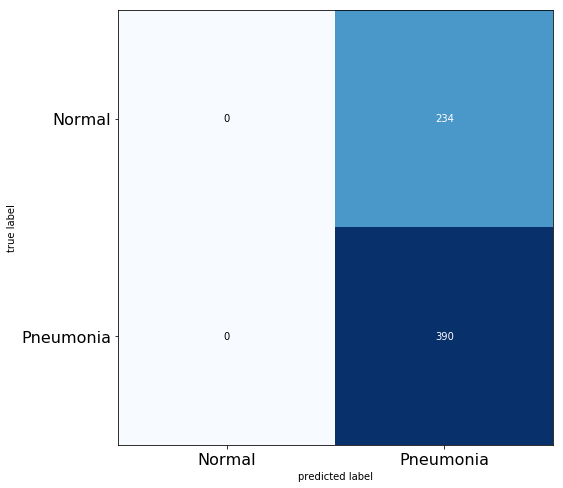

In [0]:
cm  = confusion_matrix(test2_labels, yPred)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

## 문제점과 어려움

* ### 정상 이미지가 약 1800개, 비정상 이미지가 약 3800개, 데이터 개수가 정상보다 문제가 있는 사진이 훨씬 많기 때문에 데이터 쏠림이 있는 데이터셋이다.
* ### 따라서 정상보다 문제가 있는 쪽을 더 많이 택하게 되는 모형을 만들어도 정상을 잘못 택하는 모형보다 좋다는 결과가 나올 수 있다.  
* ### 이미지 크기들이 제각각 다 달라서 제 맘대로 크기를 통일하다보니 원본보다 덜 정확해지므로 정확도가 조금 떨어지는 거 같다. 
* ### 원래 사이즈가 큰 그림이 많아서 최대한 크게 하고 싶지만 램이 감당을 못해서 최대한 적게 할 수밖에 없었다.

## New model with sampling

SAMPLING


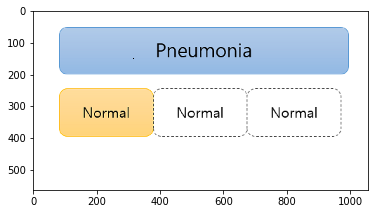

In [0]:
img_sampling = load_img('./gdrive/My Drive/samplings.png')

print('SAMPLING')
plt.imshow(img_sampling)
plt.show()

### 변수, 리스트 초기화

In [0]:
train_data = []
train_labels = []
test_data = []
test_labels = []
valid_data = []
valid_labels = []
im_width = 256
im_height = 256
num_classes = 2

### 이미지 불러오기

In [0]:
preProcessTrainData("./gdrive/My Drive/chest_xray/train/")
preProcessTestData("./gdrive/My Drive/chest_xray/test/")
preProcessValidData("./gdrive/My Drive/chest_xray/val/")
preProcessTrain2Data("./gdrive/My Drive/chest_xray/train/")
preProcessTrain2Data("./gdrive/My Drive/chest_xray/train/")

### 배열로 변환, 확인하기

In [0]:
train_data = np.array(train_data)
test_data = np.array(test_data)
valid_data = np.array(valid_data)
print(train_data.shape)
print(test_data.shape)
print(valid_data.shape)

(7917, 256, 256)
(624, 256, 256)
(16, 256, 256)


In [0]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)
valid_labels = np.array(valid_labels)
print(train_labels.shape)
print(test_labels.shape)
print(valid_labels.shape)

(7917,)
(624,)
(16,)


## reshape

### 데이터 변환하기

In [0]:
##reshape
train_data = train_data.reshape((train_data.shape)[0],(train_data.shape)[1],(train_data.shape)[2],1).astype('float32')/255
test_data = test_data.reshape((test_data.shape)[0],(test_data.shape)[1],(test_data.shape)[2],1).astype('float32')/255
valid_data = valid_data.reshape((valid_data.shape)[0],(valid_data.shape)[1],(valid_data.shape)[2],1).astype('float32')/255
print(train_data.shape)
print(test_data.shape)
print(valid_data.shape)

(7917, 256, 256, 1)
(624, 256, 256, 1)
(16, 256, 256, 1)


### one-hot 인코딩

In [0]:
train_labels.astype('uint8')
test_labels.astype('uint8')
valid_labels.astype('uint8')
train_labels = keras.utils.to_categorical(train_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)
valid_labels = keras.utils.to_categorical(valid_labels, num_classes) #one hot encoding
print(train_labels.shape)
print(test_labels.shape)
print(valid_labels.shape)

(7917, 2)
(624, 2)
(16, 2)


## New Model Keras

### 순서 섞기

In [0]:
def shuffle(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
for i in range(2):
    shuffle(train_data,train_labels)
# print(train_labels[0:100])

### 모형 층 설계

In [0]:
model = Sequential()
model.add(Conv2D(kernel_size=(3,3),filters=32,input_shape=(256, 256,
1),activation = 'relu',padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(kernel_size=(3,3),filters=32,activation="relu",padding="same"))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(kernel_size=(3,3),filters=64,padding="same"))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(kernel_size=(3,3),filters=256,activation="relu",padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(kernel_size=(3,3),filters=256,padding="same"))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(kernel_size=(3,3),filters=256,activation="relu",padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Flatten())
model.add(Dense(1024,activation="relu",kernel_regularizer=keras.regularizers.l2(0.05)))
model.add(Dropout(0.4))
model.add(Dense(1024,activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(num_classes,activation="softmax"))

model.compile(loss='categorical_crossentropy',
#               optimizer=keras.optimizers.Adam,
              optimizer ='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 256, 256, 32)      320       
_________________________________________________________________
batch_normalization_7 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
dropout_7 (Dropout)          (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 64, 32)        0         
__________

### 학습하기

In [0]:
history = model.fit(train_data, train_labels,
          batch_size=128,
          epochs=10,
          verbose=1,shuffle = True, validation_split=0.25)


Instructions for updating:
Use tf.cast instead.
Train on 5937 samples, validate on 1980 samples
Epoch 1/10
5937/5937 [==============================] - 31s 5ms/step - loss: 31.7738 - acc: 0.4952 - val_loss: 9.3276 - val_acc: 0.4919
Epoch 2/10
5937/5937 [==============================] - 20s 3ms/step - loss: 3.1019 - acc: 0.8130 - val_loss: 8.6361 - val_acc: 0.5086
Epoch 3/10
5937/5937 [==============================] - 21s 3ms/step - loss: 0.6567 - acc: 0.9473 - val_loss: 2.0876 - val_acc: 0.5783
Epoch 4/10
5937/5937 [==============================] - 21s 3ms/step - loss: 0.3417 - acc: 0.9604 - val_loss: 8.0042 - val_acc: 0.4919
Epoch 5/10
5937/5937 [==============================] - 21s 3ms/step - loss: 0.2545 - acc: 0.9690 - val_loss: 2.4100 - val_acc: 0.5101
Epoch 6/10
5937/5937 [==============================] - 21s 3ms/step - loss: 0.1841 - acc: 0.9769 - val_loss: 0.2175 - val_acc: 0.9616
Epoch 7/10
5937/5937 [==============================] - 21s 3ms/step - loss: 0.1692 - acc: 0.

### Loss 그래프

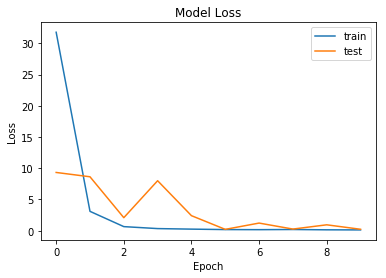

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


### Accuracy 그래프

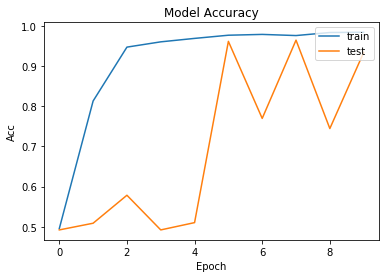

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Test셋과 Valid셋으로 정확도 측정

In [0]:
score = model.evaluate(test_data , test_labels)
score1 = model.evaluate(valid_data, valid_labels)

16/16 [==============================] - 0s 1ms/step


In [0]:
print("Test loss: ", score[0])
print("Test accuracy: ", score[1])
print("Valid loss: ", score1[0])
print("Valid accuracy: ", score1[1])


Test loss:  1.1338734053648436
Test accuracy:  0.8205128205128205
Valid loss:  0.8648409247398376
Valid accuracy:  0.8125


* ### 예측력이 80% 전후까지 올라갔다.
### 실제와 예측값 비교하기

In [0]:
yPred = model.predict(test_data, verbose=0, steps=None)
yPred = np.argmax(yPred, axis=1)
yPred = yPred.reshape(-1)

print('실제값:' , np.argmax(test_labels[0]),'예측값: ',yPred[0])    #잘 예측했다.

실제값: 1 예측값:  1


In [0]:
test2_labels = np.argmax(test_labels[:],axis=1)
print(test2_labels)
print("")
print(yPred)
# yPred[:10]

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

### confusion matrix로 정확도 확인하기

<Figure size 432x288 with 0 Axes>

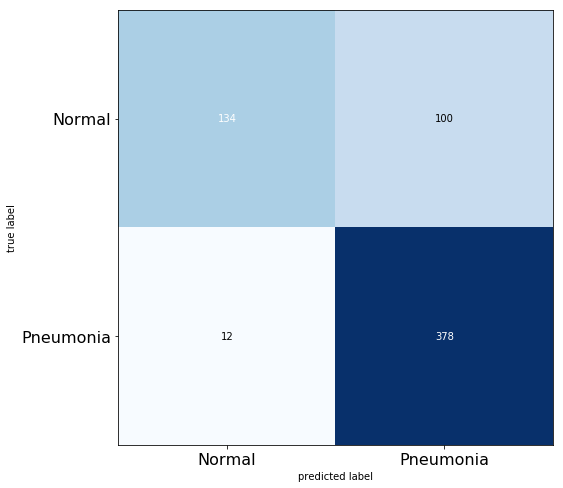

In [0]:
cm  = confusion_matrix(test2_labels, yPred)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

## 보완된 점
* ### 항상 1로만 예측하던 모형이 추가샘플링으로 비율을 비슷하게 맞춰주니 확실히 0으로 예측하는 비율이 늘었다. 아직 1로 예측하는 확률이 높긴 하지만 샘플링 하기 전보다 예측력이 좋아졌다.

## 의심되는 문제
* ### valid_data가 각 8개로 총 16개밖에 되지 않는다. valid_data로 측정한 것은 조금 믿을만하지 못하다
* ### 정상인 데이터 중 같은 데이터를 3번 반복해서 넣어줬기 때문에 train내 데이터만 잘 맞추는 과적합이 일어났다고 볼 수 있다. 그래서 test 데이터셋의 정상인 데이터을 아직 잘 못 맞추는 것이라고 예상할 수 있다.

## 아쉬운 점
* ### 메모리와 gpu가 더 좋았다면 크기를 최대한 덜 줄이고 모형설계도 더 쓸 수 있었을텐데 아쉽다